# Dollar Bill Validity

Author: Jacob Bustamante

Course Project, UC Irvine, Math 10, S23

## Introduction

The goal for this data analysis is to determine the validity of a dollar bill given the features of the dataset, and to what degree each and every feature is useful determining such. We will employ many classification tools and regression models and determine which can best predict the validity of any given bill.

## About the Data

For this dataset we have 5 features: 4 numeric features and 1 nominal feature. The four numeric features are the attributes of the image after being run through a Wavelet Transform tool, and the nominal feature is whether the bill was presumed to be a real or a forge. More information on this dataset can be found at:
https://www.openml.org/search?type=data&status=any&sort=nr_of_likes&id=1462



The file is a tuple, containing the dataframe at index 0 and the above information at index 1, how thoughtful!

In [1]:
from scipy.io.arff import loadarff 
loadarff('banknote_authentication.arff')[1]

Dataset: banknote-authentication
	V1's type is numeric
	V2's type is numeric
	V3's type is numeric
	V4's type is numeric
	Class's type is nominal, range is ('1', '2')

We have a lot of modules to import, so here are the modules each with a brief description as to how we will be using each module.

In [2]:
import pandas as pd                                   # Integral for our data analysis!
import altair as alt                                  # Useful for graphing data and visualization.
# loadarff from scipy                                 # Allows the loading of .arff files.
from sklearn.linear_model import LinearRegression     # Linear regression model.
from sklearn.linear_model import LogisticRegression   # Classification model, using sigmoid function.
from sklearn.tree import DecisionTreeClassifier       # Classification model, only one decision tree.
from sklearn.model_selection import train_test_split  # Reduces chance of overfitting.
from sklearn.decomposition import PCA                 # Principal Component Analysis tool.

### Feature Engineering
First and foremost, we have to adjust the data for use, whether it be creating new columns or adjusting pre-existing columns:
* First we import the arff file using the `scipy.io.arff` module and load it into the pandas dataframe `df`.
* We adjust the column names for better readability.
* And we insert the columns `'realBool'` and `'realDollar'` for later use.


In [3]:
df = pd.DataFrame(loadarff('banknote_authentication.arff')[0])
df.sample(5,random_state=22)

,V1,V2,V3,V4,Class
1330,-1.10050,-7.25080,6.0139,0.368950,b'2'
522,0.52855,0.96427,4.0243,-1.048300,b'1'
1337,0.23460,-4.51520,2.1195,1.444800,b'2'
599,3.92920,-2.91560,2.2129,0.308170,b'1'
977,-1.23900,-6.54100,4.8151,-0.033204,b'2'


The column names are not that helpful in distinguishing a feature from another, so we set the column names to the `cols` list.

In [4]:
cols = ['variance', 'skewness', 'curtosis', 'entropy','realBool']
df.set_axis(cols, axis='columns', inplace=True)
df.columns

Index(['variance', 'skewness', 'curtosis', 'entropy', 'realBool'], dtype='object')

Notice the `realBool` column is not very useable for classification, as it is an **object** dtype, so we will change it to a **bool** dtype.

In [5]:
df.sample()

,variance,skewness,curtosis,entropy,realBool
420,-2.484,12.1611,2.8204,-3.7418,b'1'


We want `realBool` to be a **bool**, so using the `str` accessor allows us to filter the b'1' from 'b'2'. Since b'1' is real and b'2' means forged, we want b'1' to mean True and else False.

In [6]:
df['realBool'] = df['realBool'].astype(str).str.contains('1')

We also create the new column `'realDollar'` to store the integer value of the bool.

In [7]:
df['realDollar'] = df['realBool'].astype(int)
df.sample(5,random_state=22)

,variance,skewness,curtosis,entropy,realBool,realDollar
1330,-1.10050,-7.25080,6.0139,0.368950,False,0
522,0.52855,0.96427,4.0243,-1.048300,True,1
1337,0.23460,-4.51520,2.1195,1.444800,False,0
599,3.92920,-2.91560,2.2129,0.308170,True,1
977,-1.23900,-6.54100,4.8151,-0.033204,False,0


## Principal Component Analysis (PCA)

Sklearn's `PCA` is great for identifying the greatest variance features in large Dataframes with numerous features, but just for this dataset we wish to measure the relative importance of each element in the Dataframe and determine the most impactful feature.

In [8]:
from sklearn.decomposition import PCA

We create the principal component classifier fitted to the Dataframe.

In [9]:
pca = PCA(n_components=4, random_state=22).fit(df[cols[:-1]], df['realBool'])

From the `explained_variance_ratio_`, we can determine which feature from the dollar photographs is best in determining a forgery, comparatively to the other features.

We create `df_coefs` to display each feature's relative proficiency in forgery identification.

In [10]:
df_coefs = pd.DataFrame([list(pca.explained_variance_ratio_)], columns=cols[:-1])
df_coefs

,variance,skewness,curtosis,entropy
0,0.761324,0.141905,0.067018,0.029753


Notably, `variance` is by far the best for determining a forgery, being over **5 times** better at measuring the likelyhood of a forgery than the next best feature, `skewness`!

## Plotting the data

Let's get a better look at our data, and given variance is the best at classifying forgeries and real bills, let's plot variance with the other features and try to identify any clear patterns in the data.

Along the way, we'll determine the best regression tool for the quantitative data.

We create the `make_line_chart` and `make_circle_chart` functions to help create the necessary altair charts. This helps simplify the process of data visualization.

In [11]:
def make_line_chart(df, feat, output):
    return alt.Chart(df).mark_line(color='red').encode(x=feat, y=output)
def make_circle_chart(df, feat, output):
    return alt.Chart(df).mark_circle().encode(x=feat, y=output, color='realBool')

We plot `variance` with each other quantitative feature of the data, using color to differentiate the presumed forges from the real.

In [12]:
[display(make_circle_chart(df, 'variance', col)) for col in cols[1:-1]]

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

[None, None, None]

It's notable the range where variance has trouble predicting the validity of a bill is [-2,2], where for variance values >2 the bill is highly likely to be real, and for values <-2 it is highly likely to be a forgery. 

Furthermore, it is clear the relationship between the variables is non-linear, so now using `poly_fit()` we can find a **best fit** regression model for the data.

We make use of the code from our Worksheet #12 to model the data using `PolynomialFeatures` and `Pipeline` from sklearn. 
Link:
https://deepnote.com/workspace/math-10-b179-2fef3736-b933-4ebb-a4e1-69d5a22c939f/project/Worksheet-12-Jacob-Bustamante-fdc251b5-bac1-49ad-bfcb-1a5b3029fdc6/notebook/Worksheet12-e0f43b71877d4d15aa254a9f86f55c49

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
def poly_fit_var(df, d, n, rs, col, color):
    df_copy = df.copy()
    df_sub = df.sample(n,random_state=rs)
    pipe = Pipeline([
        ("poly",PolynomialFeatures(degree=d,include_bias=False)),
        ("reg",LinearRegression())
    ])
    pipe.fit(df_sub[["variance"]],df_sub[col])
    df_copy[col] = pipe.predict(df_copy[["variance"]])
    c = alt.Chart(df_copy).mark_line(color=color,clip=True).encode(
        x="variance", 
        y = alt.Y(col, scale=alt.Scale(domain=(-10,20)))
    )
    return c

We arbitrarily choose variance and curtosis, as I find those features' relationship to be the most **interesting**.

In [14]:
c = make_circle_chart(df, 'variance', 'curtosis')

In [15]:
d_col = [(3, 'red'), (7, 'green'), (10, 'blue')]
chart_list = [poly_fit_var(df, degree, 100, 22, 'curtosis', color) for degree, color in d_col]
alt.layer(c, *chart_list)


alt.LayerChart(...)

From the chart there appears to be **no** line of best fit, as the data appears to be non-linear. 
This makes sense, given the clear split in the data as variance decreases.

## Logistic Regression

Let's see if Logistic Regression will agree with our findings from our Principal Component Analysis in determining the (single) best attribute to determine the real from the fake!

We create the `dollar_log_prob()` function to fit each singular column to the `LogisticRegression` model, returning the score for its classification success rate.

In [16]:
def dollar_log_prob(df,col):
    return LogisticRegression().fit(df[[col]],df['realBool']).score(df[[col]],df['realBool'])

Using `df_coef` we can store and display each feature's success rate in predicting a dollar's validity alongside the PCA's scoring of each attribute.

In [18]:
df_coefs.loc[1] = [dollar_log_prob(df,feat) for feat in df.columns[:4]]
df_coefs

,variance,skewness,curtosis,entropy
0,0.761324,0.141905,0.067018,0.029753
1,0.844752,0.650146,0.610058,0.555394


According to the logistic regression, the best feature for determining a forged dollar is the variance of the image, at an 84% success rate. Skewness and curtosis are better than guessing with both being over 60%. Entropy is the lowest with 55%, barely better than just guessing!  

It's clear then that both classification models **agree** in variance's importance in forgery prediction.

## Graphing Logistic Regression

Let's graph just the `variance` feature, as of course it is the most successful predictor for a forgery.

First, let's create the global instance of the logistic regression of the `variance` feature.
(all our logistic regression instances were local to the `dollar_log_prob` function)

In [20]:
clf = LogisticRegression().fit(df[['variance']], df['realDollar'])

Notice from `clf.classes_`, the structure of the data from `clf.predict_proba` will have the forge probability (0) first, then the real probability (1) next.

In [21]:
print(clf.classes_)
print(clf.predict_proba(df[['variance']])[:3,:])

[0 1]
[[0.02402549 0.97597451]
 [0.00959921 0.99040079]
 [0.01887641 0.98112359]]


We create the `pred_prob` column to store the classifier `clf`'s confidence level for each prediction, given the variance.

In [22]:
df['pred_prob'] = clf.predict_proba(df[['variance']])[:,1]

In [23]:
print(clf.predict_proba(df[['variance']])[:,1][0])

0.9759745071183341


In [24]:
make_circle_chart(df,'variance', 'realDollar') + make_line_chart(df,'variance', 'pred_prob')

alt.LayerChart(...)

## Decision Tree Classification

We use `train_test_split` to test the effectiveness of the Decision Tree Classifier: inputting our dataframe minus the last column, as this is our desired element `realBool`. 

In [27]:
X_train, X_test, y_train, y_test = train_test_split(df[cols[:-1]],df['realBool'], train_size=.6, random_state=22)

In [28]:
dtc = DecisionTreeClassifier(max_leaf_nodes=8).fit(X_train,y_train)

We print the effectiveness of the `DecisionTreeClassifier` in modeling the dollar bill validity dataset, displaying both the train set and test set's success rate.

In [30]:
[print(dtc.score(X,y)) for X,y in [[X_train,y_train],[X_test,y_test]]]

0.9538274605103281
0.941712204007286


[None, None]

Given the score of the training and test sets are both above 94%, it is clear from the test data set that using **8** max leaf nodes is quite sufficient for classification without **overfitting**. 

Here is the `DecisionTree` for classifying each bill.

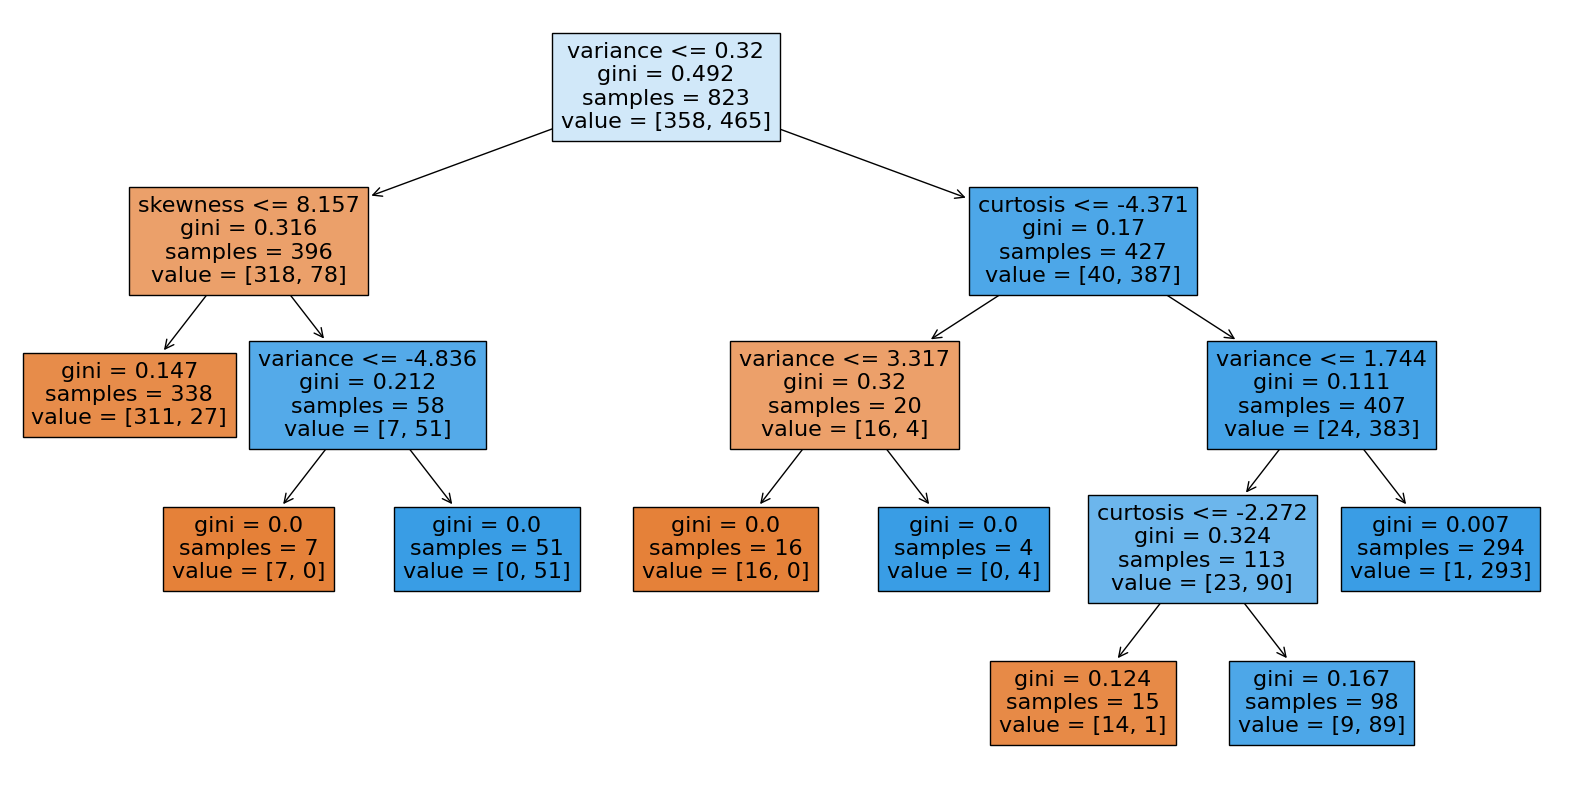

In [31]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(20,10))
_ = plot_tree(dtc, feature_names=dtc.feature_names_in_, filled=True)

Because the singular decision tree classifier is quite **accurate** as is, a Random Forest Classification from sklearn is not necessary.

## Summary

The importance in the variance of the bill cannot be understated, as the other features of a bill: skewness, curtosis, and entropy; all pail in comparison to the success rate variance has in identifying forgeries from real bills. Using polynomial regression models it is clear the relationships between each feature from the Wavelet Transform tool are non-linear and hard to model accurately. Lastly using decision tree classification with a leaf node limit of roughly 20 is highly successful in forgery identification, with a 94% success rate in separating the forges from the real bills.

All in all, given that the data set is from the features gathered from a Wavelet Transform tool- a data processing and analyzing tool itself- most findings we can gather are in regards to the functionality of the data tool itself, as we know no information on the bills themselves. However, one key insight into data analysis that cannot be understated is that variance in a data set cannot be overlooked, as variance from the norm can be key in classification and categorization, as this data set conveys.

## References

### Source of the dataset:
Volker Lohweg (2013). UCI Machine Learning Repository [https://archive.ics.uci.edu/ml/datasets/banknote+authentication]. University of Applied Sciences, Ostwestfalen-Lippe

### Code from Worksheet #12, specifically the **poly_fit()** function.
Jacob Bustamante (2023). deepnote
[https://deepnote.com/workspace/math-10-b179-2fef3736-b933-4ebb-a4e1-69d5a22c939f/project/Worksheet-12-Jacob-Bustamante-fdc251b5-bac1-49ad-bfcb-1a5b3029fdc6/notebook/Worksheet12-e0f43b71877d4d15aa254a9f86f55c49]. UC Irvine

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=36d2445d-311e-45a5-bf15-339a3a61ee77' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>